<a href="https://colab.research.google.com/github/HarisankarRNR/Dual_Track_Model-Image_Classification/blob/main/Swin_Transformer-Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchinfo
!pip install timm # kaggle doesnt have it installed by default
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import numpy as np
import pandas as pd
import os

import PIL
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision
import torch.optim as optim
import timm
from  torchvision.ops.deform_conv import DeformConv2d
import torchinfo
import sys
from tqdm import tqdm
import time
import copy
import os

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                # transforms.RandomRotation(45),
                                # transforms.RandomVerticalFlip(),
                                # transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                ])
test_transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                    ])

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

train_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/train'
valid_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/val'
test_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/test'

train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(test_dataset_path,transform=test_transform)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, **kwargs)
valid_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, **kwargs)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

CLASSES = train_dataset.classes
train_len = len(train_dataset)
valid_len = len(valid_dataset)
test_len = len(test_dataset)

In [ ]:
dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}
dataset_sizes = {
    "train": train_len,
    "val": valid_len
}

In [ ]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat


class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)


class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        # self.mlp_head = nn.Sequential(
        #     nn.LayerNorm(hidden_dim * 8),
        #     nn.Linear(hidden_dim * 8, num_classes)
        # )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        # x = x.mean(dim=[2, 3])
        return x


def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=3, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input,dim=1)
        # print("logpt is:",logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        # print("loss is :",loss)
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
class ChannelShuffle(nn.Module):
  def __init__(self,groups):
    super().__init__()
    self.groups = groups

  def forward(self,x):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // self.groups
    x = x.view(batch, self.groups, channels_per_group, height, width)
    # print(x.shape)
    x = torch.transpose(x, 1, 2).contiguous()
    # print(x.shape)
    x = x.view(batch, channels, height, width)
    # print(x.shape)
    return x

In [ ]:
class GSDWR(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.groupconv = nn.Conv2d(in_channels = in_channels,out_channels = out_channels,kernel_size = 1,stride=1,groups = 3)
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(0.3)
    self.shuffle = ChannelShuffle(2)

    self.depthwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size = 2,stride=2, groups = 2)
    self.pointwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels*2, kernel_size = 1)

  def forward(self,x):
    inpt = x
    x = self.act1(self.groupconv(x))
    x = self.drop1(x)
    x = self.shuffle(x)
    x = torch.add(x,inpt)
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

In [ ]:
class DeformableConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size=1)
    self.act1 = nn.ReLU()
    self.deformconv = DeformConv2d(in_channels = in_channels, out_channels =out_channels, kernel_size=1,stride = 1)
    # self.deformconv = deform_conv2d(3,3,3,stride=2)
    self.act2 = nn.ReLU()
    self.depthwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels, kernel_size = 2, stride=2, groups = 2)
    self.pointwise = nn.Conv2d(in_channels=in_channels,out_channels = out_channels*2, kernel_size = 1)

  def forward(self,x):
    # print(x.shape)
    offset = x
    x = self.act1(self.conv1(x))
    x = self.act2(self.deformconv(x,offset))
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x

In [ ]:
class LinearLayer(nn.Module):
  def __init__(self,input):
    super().__init__()
    # self.avgpool = torch.mean()
    self.linear1 = nn.Linear(input, 512)
    self.act1 = nn.ReLU()
    self.drop = nn.Dropout(0.3)
    self.linear2 = nn.Linear(512, 4)

  def forward(self,x):
    # print(x.shape())
    x = torch.mean(x,dim=[2,3])
    # x = self.flat(x)
    x = self.act1(self.linear1(x))
    x = self.drop(x)
    x = self.linear2(x)
    return x

In [ ]:
class swin_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 2,stride=2)
    self.swin_out = SwinTransformer(hidden_dim = 12,
                      layers = (2,2,6,2),
                      heads = (3,6,12,24),
                      channels = 6,
                      num_classes = 4,
                      downscaling_factors=(2, 2, 2, 2)
                      )
  def forward(self,x):
    x = self.conv1(x)
    x = self.swin_out(x)
    return x

In [ ]:
class CNN_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 2,stride=2)
    self.gsdwr1 = GSDWR(6,6)
    self.batchnorm1 = nn.BatchNorm2d(12)
    self.deform1 = DeformableConvBlock(12,12)
    self.batchnorm2 = nn.BatchNorm2d(24)
    self.gsdwr2 = GSDWR(24,24)
    self.batchnorm3 = nn.BatchNorm2d(48)
    self.deform2 = DeformableConvBlock(48,48)

  def forward(self,x):
    x = self.conv1(x)
    x = self.gsdwr1(x)
    x = self.batchnorm1(x)
    x = self.deform1(x)
    x = self.batchnorm2(x)
    x = self.gsdwr2(x)
    x = self.batchnorm3(x)
    x = self.deform2(x)
    return x


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.swin_out = swin_model()
    self.cnn_out = CNN_model()
    self.linear = LinearLayer(192)

  def forward(self,x):
    x1 = self.swin_out(x)
    x2 = self.cnn_out(x)
    x = torch.cat([x1,x2],dim=1)
    x = self.linear(x)
    return x

In [ ]:
model = Model()
torchinfo.summary(model, (32,3, 224, 224))

Layer (type:depth-idx)                                                 Output Shape              Param #
Model                                                                  [32, 4]                   --
├─swin_model: 1-1                                                      [32, 96, 7, 7]            --
│    └─Conv2d: 2-1                                                     [32, 6, 112, 112]         78
│    └─SwinTransformer: 2-2                                            [32, 96, 7, 7]            --
│    │    └─StageModule: 3-1                                           [32, 12, 56, 56]          17,200
│    │    └─StageModule: 3-2                                           [32, 24, 28, 28]          52,876
│    │    └─StageModule: 3-3                                           [32, 48, 14, 14]          575,916
│    │    └─StageModule: 3-4                                           [32, 96, 7, 7]            762,868
├─CNN_model: 1-2                                                       [32, 9

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
# criterion = FocalLoss(alpha =class_weights,gamma=2)
criterion = criterion.to(device)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)
os.chdir("/content/drive/MyDrive/CCPS_research/logs_grapes")

In [ ]:
# checkpoint = torch.load(f"checkpoints_total_balanced6/model25.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(loss)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, path, train_log, valid_log, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    df_train = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_acc'])
    df_val = pd.DataFrame(columns = ['epoch','val_loss','val_acc'])
    for epoch in range(1,num_epochs+1):
        print(f'Epoch {epoch}/{num_epochs}')
        print("-"*10)


        if not os.path.isdir(path):
          os.mkdir(path)
        # else:
        #   checkpoint = torch.load(f"checkpoints/model{epoch-1}.pt")
        #   model.load_state_dict(checkpoint['model_state_dict'])
        #   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          # epoch = checkpoint['epoch']
          # loss = checkpoint['loss']

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    # print("outputs are: ",outputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    # print("\nEntering loss")
                    loss = criterion(outputs, labels)
                    # print("loss obtained: ",loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step() # step at end of epoch
            # print(type(epoch))
            # print(type(epoch_loss))
            # print(type(epoch_acc))
            if phase=='train':
              # print("Done")
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'train_loss': [epoch_loss],'train_acc':[epoch_acc.cpu()] })
              # print("done2")
              df_train = pd.concat([df_train, df_new_row])
              df_train.to_csv(f'{path}/{train_log}.csv')
            elif phase=='val':
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'val_loss': [epoch_loss],'val_acc':[epoch_acc.cpu()] })
              df_val = pd.concat([df_val, df_new_row])
              df_val.to_csv(f'{path}/{valid_log}.csv')
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            ## save torch model for checkpoints
            if epoch%5==0:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': epoch_loss,
              }, f"{path}/model{epoch}.pt")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()

    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, "swin+cnn_grapes4","train_cnn","val_cnn",num_epochs=100)

Epoch 1/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.48it/s]


train Loss: 1.3535 Acc: 0.3174


100%|██████████| 29/29 [00:04<00:00,  6.91it/s]


val Loss: 1.1204 Acc: 0.5210

Epoch 2/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.23it/s]


train Loss: 1.0019 Acc: 0.5370


100%|██████████| 29/29 [00:04<00:00,  5.83it/s]


val Loss: 0.7987 Acc: 0.6268

Epoch 3/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.7225 Acc: 0.6668


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.6502 Acc: 0.6828

Epoch 4/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.6298 Acc: 0.7308


100%|██████████| 29/29 [00:05<00:00,  5.45it/s]


val Loss: 0.5926 Acc: 0.7249

Epoch 5/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.31it/s]


train Loss: 0.5779 Acc: 0.7602


100%|██████████| 29/29 [00:04<00:00,  7.03it/s]


val Loss: 0.5180 Acc: 0.7648

Epoch 6/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.5283 Acc: 0.7786


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.5095 Acc: 0.7691

Epoch 7/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


train Loss: 0.5139 Acc: 0.7761


100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


val Loss: 0.5270 Acc: 0.7616

Epoch 8/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.4575 Acc: 0.8012


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.4481 Acc: 0.8037

Epoch 9/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.29it/s]


train Loss: 0.4180 Acc: 0.8275


100%|██████████| 29/29 [00:04<00:00,  6.06it/s]


val Loss: 0.4185 Acc: 0.8198

Epoch 10/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.30it/s]


train Loss: 0.4220 Acc: 0.8235


100%|██████████| 29/29 [00:04<00:00,  6.58it/s]


val Loss: 0.5368 Acc: 0.7487

Epoch 11/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.47it/s]


train Loss: 0.4088 Acc: 0.8264


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.4425 Acc: 0.8004

Epoch 12/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


train Loss: 0.3934 Acc: 0.8350


100%|██████████| 29/29 [00:05<00:00,  5.15it/s]


val Loss: 0.4067 Acc: 0.8436

Epoch 13/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.43it/s]


train Loss: 0.3804 Acc: 0.8436


100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


val Loss: 0.4364 Acc: 0.8231

Epoch 14/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.3516 Acc: 0.8562


100%|██████████| 29/29 [00:04<00:00,  6.25it/s]


val Loss: 0.5598 Acc: 0.7735

Epoch 15/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.19it/s]


train Loss: 0.3626 Acc: 0.8501


100%|██████████| 29/29 [00:04<00:00,  6.63it/s]


val Loss: 0.3781 Acc: 0.8490

Epoch 16/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.43it/s]


train Loss: 0.3836 Acc: 0.8465


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.4307 Acc: 0.8242

Epoch 17/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


train Loss: 0.3250 Acc: 0.8681


100%|██████████| 29/29 [00:05<00:00,  5.19it/s]


val Loss: 0.3452 Acc: 0.8641

Epoch 18/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


train Loss: 0.3227 Acc: 0.8731


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.3795 Acc: 0.8490

Epoch 19/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


train Loss: 0.3292 Acc: 0.8713


100%|██████████| 29/29 [00:04<00:00,  6.64it/s]


val Loss: 0.4847 Acc: 0.8015

Epoch 20/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


train Loss: 0.3093 Acc: 0.8789


100%|██████████| 29/29 [00:05<00:00,  5.79it/s]


val Loss: 0.3404 Acc: 0.8695

Epoch 21/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.48it/s]


train Loss: 0.2902 Acc: 0.8807


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.3428 Acc: 0.8619

Epoch 22/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


train Loss: 0.3158 Acc: 0.8731


100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


val Loss: 0.3648 Acc: 0.8619

Epoch 23/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.41it/s]


train Loss: 0.2827 Acc: 0.8868


100%|██████████| 29/29 [00:04<00:00,  7.06it/s]


val Loss: 0.3410 Acc: 0.8684

Epoch 24/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.41it/s]


train Loss: 0.3164 Acc: 0.8645


100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


val Loss: 0.4136 Acc: 0.8393

Epoch 25/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.43it/s]


train Loss: 0.3137 Acc: 0.8695


100%|██████████| 29/29 [00:05<00:00,  5.28it/s]


val Loss: 0.5111 Acc: 0.8004

Epoch 26/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.3007 Acc: 0.8796


100%|██████████| 29/29 [00:04<00:00,  6.92it/s]


val Loss: 0.3748 Acc: 0.8490

Epoch 27/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


train Loss: 0.2603 Acc: 0.8965


100%|██████████| 29/29 [00:05<00:00,  5.67it/s]


val Loss: 0.3533 Acc: 0.8652

Epoch 28/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.22it/s]


train Loss: 0.2615 Acc: 0.8965


100%|██████████| 29/29 [00:04<00:00,  6.76it/s]


val Loss: 0.3661 Acc: 0.8490

Epoch 29/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


train Loss: 0.2495 Acc: 0.8983


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.3846 Acc: 0.8457

Epoch 30/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.44it/s]


train Loss: 0.2752 Acc: 0.8853


100%|██████████| 29/29 [00:05<00:00,  5.18it/s]


val Loss: 0.3512 Acc: 0.8554

Epoch 31/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.2587 Acc: 0.8994


100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


val Loss: 0.4298 Acc: 0.8209

Epoch 32/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.2373 Acc: 0.9029


100%|██████████| 29/29 [00:04<00:00,  5.85it/s]


val Loss: 0.3135 Acc: 0.8738

Epoch 33/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.26it/s]


train Loss: 0.2265 Acc: 0.9091


100%|██████████| 29/29 [00:04<00:00,  6.86it/s]


val Loss: 0.3810 Acc: 0.8522

Epoch 34/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


train Loss: 0.2262 Acc: 0.9087


100%|██████████| 29/29 [00:04<00:00,  6.96it/s]


val Loss: 0.3527 Acc: 0.8511

Epoch 35/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


train Loss: 0.2358 Acc: 0.9105


100%|██████████| 29/29 [00:05<00:00,  5.13it/s]


val Loss: 0.3472 Acc: 0.8565

Epoch 36/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


train Loss: 0.2014 Acc: 0.9216


100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


val Loss: 0.4512 Acc: 0.8242

Epoch 37/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


train Loss: 0.2040 Acc: 0.9177


100%|██████████| 29/29 [00:04<00:00,  6.01it/s]


val Loss: 0.2859 Acc: 0.8910

Epoch 38/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.27it/s]


train Loss: 0.2143 Acc: 0.9127


100%|██████████| 29/29 [00:04<00:00,  6.54it/s]


val Loss: 0.3160 Acc: 0.8770

Epoch 39/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


train Loss: 0.2184 Acc: 0.9105


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.7936 Acc: 0.7292

Epoch 40/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.2062 Acc: 0.9180


100%|██████████| 29/29 [00:05<00:00,  4.92it/s]


val Loss: 0.3619 Acc: 0.8641

Epoch 41/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.33it/s]


train Loss: 0.1883 Acc: 0.9231


100%|██████████| 29/29 [00:04<00:00,  7.12it/s]


val Loss: 0.2705 Acc: 0.8889

Epoch 42/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.1768 Acc: 0.9310


100%|██████████| 29/29 [00:04<00:00,  6.35it/s]


val Loss: 0.2613 Acc: 0.9029

Epoch 43/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.29it/s]


train Loss: 0.1865 Acc: 0.9299


100%|██████████| 29/29 [00:04<00:00,  6.15it/s]


val Loss: 0.3245 Acc: 0.8695

Epoch 44/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.1739 Acc: 0.9306


100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


val Loss: 0.3456 Acc: 0.8684

Epoch 45/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.43it/s]


train Loss: 0.1740 Acc: 0.9317


100%|██████████| 29/29 [00:05<00:00,  5.07it/s]


val Loss: 0.4397 Acc: 0.8339

Epoch 46/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.1635 Acc: 0.9360


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.4323 Acc: 0.8371

Epoch 47/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.43it/s]


train Loss: 0.1547 Acc: 0.9367


100%|██████████| 29/29 [00:04<00:00,  6.68it/s]


val Loss: 0.2771 Acc: 0.8943

Epoch 48/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.20it/s]


train Loss: 0.1642 Acc: 0.9324


100%|██████████| 29/29 [00:04<00:00,  6.14it/s]


val Loss: 0.2647 Acc: 0.8964

Epoch 49/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.44it/s]


train Loss: 0.1643 Acc: 0.9357


100%|██████████| 29/29 [00:04<00:00,  6.79it/s]


val Loss: 0.3282 Acc: 0.8846

Epoch 50/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


train Loss: 0.1503 Acc: 0.9454


100%|██████████| 29/29 [00:05<00:00,  5.11it/s]


val Loss: 0.2574 Acc: 0.9029

Epoch 51/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.1441 Acc: 0.9475


100%|██████████| 29/29 [00:04<00:00,  7.17it/s]


val Loss: 0.3116 Acc: 0.8867

Epoch 52/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.46it/s]


train Loss: 0.1572 Acc: 0.9353


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.2911 Acc: 0.8900

Epoch 53/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.26it/s]


train Loss: 0.1413 Acc: 0.9472


100%|██████████| 29/29 [00:05<00:00,  5.77it/s]


val Loss: 0.2802 Acc: 0.9061

Epoch 54/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


train Loss: 0.1149 Acc: 0.9554


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.3346 Acc: 0.8857

Epoch 55/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.1212 Acc: 0.9536


100%|██████████| 29/29 [00:05<00:00,  5.31it/s]


val Loss: 0.3991 Acc: 0.8652

Epoch 56/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.29it/s]


train Loss: 0.1254 Acc: 0.9508


100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


val Loss: 0.2732 Acc: 0.8943

Epoch 57/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


train Loss: 0.1107 Acc: 0.9547


100%|██████████| 29/29 [00:04<00:00,  6.60it/s]


val Loss: 0.2859 Acc: 0.8943

Epoch 58/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.32it/s]


train Loss: 0.1111 Acc: 0.9558


100%|██████████| 29/29 [00:04<00:00,  5.86it/s]


val Loss: 0.3128 Acc: 0.8910

Epoch 59/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.1098 Acc: 0.9590


100%|██████████| 29/29 [00:04<00:00,  7.15it/s]


val Loss: 0.2917 Acc: 0.8910

Epoch 60/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


train Loss: 0.1101 Acc: 0.9561


100%|██████████| 29/29 [00:05<00:00,  5.48it/s]


val Loss: 0.3609 Acc: 0.8781

Epoch 61/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.21it/s]


train Loss: 0.0864 Acc: 0.9673


100%|██████████| 29/29 [00:04<00:00,  6.86it/s]


val Loss: 0.3268 Acc: 0.8910

Epoch 62/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.1004 Acc: 0.9641


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.3089 Acc: 0.8943

Epoch 63/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.30it/s]


train Loss: 0.1077 Acc: 0.9623


100%|██████████| 29/29 [00:05<00:00,  5.49it/s]


val Loss: 0.2352 Acc: 0.9148

Epoch 64/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.41it/s]


train Loss: 0.1200 Acc: 0.9576


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.3288 Acc: 0.8813

Epoch 65/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.1157 Acc: 0.9551


100%|██████████| 29/29 [00:05<00:00,  5.73it/s]


val Loss: 0.2947 Acc: 0.8954

Epoch 66/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.0811 Acc: 0.9712


100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


val Loss: 0.2668 Acc: 0.9040

Epoch 67/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.41it/s]


train Loss: 0.0913 Acc: 0.9684


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.3913 Acc: 0.8867

Epoch 68/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.26it/s]


train Loss: 0.0792 Acc: 0.9730


100%|██████████| 29/29 [00:05<00:00,  5.41it/s]


val Loss: 0.2852 Acc: 0.9094

Epoch 69/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.42it/s]


train Loss: 0.0683 Acc: 0.9741


100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


val Loss: 0.3775 Acc: 0.8921

Epoch 70/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


train Loss: 0.0689 Acc: 0.9774


100%|██████████| 29/29 [00:05<00:00,  5.68it/s]


val Loss: 0.2783 Acc: 0.9115

Epoch 71/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.33it/s]


train Loss: 0.0659 Acc: 0.9770


100%|██████████| 29/29 [00:04<00:00,  6.56it/s]


val Loss: 0.2875 Acc: 0.9105

Epoch 72/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.33it/s]


train Loss: 0.0611 Acc: 0.9795


100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


val Loss: 0.3900 Acc: 0.8975

Epoch 73/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


train Loss: 0.0748 Acc: 0.9723


100%|██████████| 29/29 [00:05<00:00,  5.27it/s]


val Loss: 0.3321 Acc: 0.9094

Epoch 74/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


train Loss: 0.1069 Acc: 0.9633


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.3158 Acc: 0.9040

Epoch 75/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


train Loss: 0.0657 Acc: 0.9752


100%|██████████| 29/29 [00:04<00:00,  5.91it/s]


val Loss: 0.2214 Acc: 0.9234

Epoch 76/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.21it/s]


train Loss: 0.0462 Acc: 0.9845


100%|██████████| 29/29 [00:04<00:00,  6.83it/s]


val Loss: 0.2748 Acc: 0.9169

Epoch 77/100
----------


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


train Loss: 0.0617 Acc: 0.9738


100%|██████████| 29/29 [00:04<00:00,  6.88it/s]


val Loss: 0.2311 Acc: 0.9137

Epoch 78/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


train Loss: 0.0721 Acc: 0.9716


100%|██████████| 29/29 [00:05<00:00,  5.11it/s]


val Loss: 0.2417 Acc: 0.9191

Epoch 79/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


train Loss: 0.0355 Acc: 0.9892


100%|██████████| 29/29 [00:04<00:00,  6.95it/s]


val Loss: 0.2926 Acc: 0.9159

Epoch 80/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


train Loss: 0.0488 Acc: 0.9817


100%|██████████| 29/29 [00:05<00:00,  5.77it/s]


val Loss: 0.3008 Acc: 0.9191

Epoch 81/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.31it/s]


train Loss: 0.0664 Acc: 0.9766


100%|██████████| 29/29 [00:04<00:00,  6.81it/s]


val Loss: 0.2738 Acc: 0.9245

Epoch 82/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.33it/s]


train Loss: 0.0681 Acc: 0.9756


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.2638 Acc: 0.9137

Epoch 83/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


train Loss: 0.0557 Acc: 0.9795


100%|██████████| 29/29 [00:05<00:00,  5.05it/s]


val Loss: 0.2716 Acc: 0.9169

Epoch 84/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.41it/s]


train Loss: 0.0428 Acc: 0.9849


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.3518 Acc: 0.8997

Epoch 85/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


train Loss: 0.0486 Acc: 0.9817


100%|██████████| 29/29 [00:04<00:00,  6.12it/s]


val Loss: 0.3051 Acc: 0.9223

Epoch 86/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.28it/s]


train Loss: 0.0378 Acc: 0.9867


100%|██████████| 29/29 [00:04<00:00,  6.51it/s]


val Loss: 0.3027 Acc: 0.9083

Epoch 87/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


train Loss: 0.0334 Acc: 0.9896


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.2899 Acc: 0.9213

Epoch 88/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


train Loss: 0.0319 Acc: 0.9878


100%|██████████| 29/29 [00:05<00:00,  5.05it/s]


val Loss: 0.3141 Acc: 0.9169

Epoch 89/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.29it/s]


train Loss: 0.0353 Acc: 0.9878


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.4517 Acc: 0.8846

Epoch 90/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.0369 Acc: 0.9871


100%|██████████| 29/29 [00:05<00:00,  5.26it/s]


val Loss: 0.5445 Acc: 0.8662

Epoch 91/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.13it/s]


train Loss: 0.0395 Acc: 0.9878


100%|██████████| 29/29 [00:04<00:00,  7.18it/s]


val Loss: 0.2767 Acc: 0.9234

Epoch 92/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.34it/s]


train Loss: 0.0260 Acc: 0.9889


100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


val Loss: 0.3053 Acc: 0.9299

Epoch 93/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.27it/s]


train Loss: 0.0223 Acc: 0.9914


100%|██████████| 29/29 [00:05<00:00,  5.23it/s]


val Loss: 0.3216 Acc: 0.9223

Epoch 94/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


train Loss: 0.0244 Acc: 0.9892


100%|██████████| 29/29 [00:04<00:00,  6.85it/s]


val Loss: 0.3596 Acc: 0.9051

Epoch 95/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.24it/s]


train Loss: 0.0283 Acc: 0.9914


100%|██████████| 29/29 [00:05<00:00,  5.67it/s]


val Loss: 0.2950 Acc: 0.9213

Epoch 96/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.19it/s]


train Loss: 0.0446 Acc: 0.9874


100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


val Loss: 0.3323 Acc: 0.9126

Epoch 97/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.32it/s]


train Loss: 0.0552 Acc: 0.9835


100%|██████████| 29/29 [00:04<00:00,  6.83it/s]


val Loss: 0.2535 Acc: 0.9310

Epoch 98/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.18it/s]


train Loss: 0.0247 Acc: 0.9925


100%|██████████| 29/29 [00:05<00:00,  5.30it/s]


val Loss: 0.2611 Acc: 0.9299

Epoch 99/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.34it/s]


train Loss: 0.0277 Acc: 0.9903


100%|██████████| 29/29 [00:04<00:00,  6.93it/s]


val Loss: 0.4068 Acc: 0.9126

Epoch 100/100
----------


100%|██████████| 87/87 [00:16<00:00,  5.31it/s]


train Loss: 0.0458 Acc: 0.9853


100%|██████████| 29/29 [00:05<00:00,  5.36it/s]


val Loss: 0.2791 Acc: 0.9234

Training complete in 35m 3s
Best Val Acc: 0.9310


In [ ]:
checkpoint = torch.load(f"swin+cnn_grapes3/model100.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(loss)

In [ ]:
predictions = []
label = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True): # no autograd makes validation go faster
        outputs = model(inputs)
        # print("outputs are: ",outputs)
        _, preds = torch.max(outputs, 1) # used for accuracy
        for i in preds:
          predictions.append(i)
        for i in labels:
          label.append(i)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


In [ ]:
predictions_cpu = [int(i.cpu().numpy()) for i in predictions]
label_cpu = [int(i.cpu().numpy()) for i in label]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_cpu, predictions_cpu,target_names=CLASSES, zero_division = 0,digits=4))

                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9576    0.9576    0.9576       236
              Grape___Esca_(Black_Measles)     0.9613    0.9820    0.9715       278
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     1.0000    0.9769    0.9883       216
                           Grape___healthy     1.0000    0.9950    0.9975       200

                                  accuracy                         0.9774       930
                                 macro avg     0.9797    0.9779    0.9787       930
                              weighted avg     0.9777    0.9774    0.9775       930



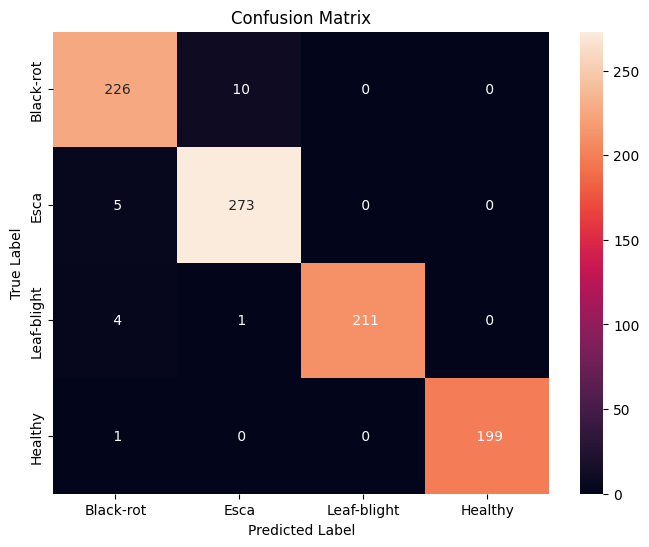

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(label_cpu, predictions_cpu)

labels = ['Black-rot','Esca','Leaf-blight','Healthy']
# cm_str = np.asarray(cf_matrix, dtype=str)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot = True, fmt = ' ',xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('/content/confusion_matrix_cnn_swin.pdf', bbox_inches='tight')
plt.savefig('/content/confusion_matrix_cnn_swin.png', bbox_inches='tight')

plt.show()